In [1]:
import torch
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import numpy as np
from sklearn.metrics import classification_report
from transformers import TOKENIZER_MAPPING, AutoModelForSequenceClassification, AutoTokenizer, AdamW, get_linear_schedule_with_warmup, XLMRobertaTokenizer, XLMRobertaForSequenceClassification
import os
from dataset import Dataset
import pandas as pd

In [2]:
TOKENIZER_NAME = "sentence-transformers/paraphrase-xlm-r-multilingual-v1"
MODEL_NAME = "sentence-transformers/paraphrase-xlm-r-multilingual-v1"
LEARNING_RATE = 3e-5

EPOCHS = 4
BATCH_SIZE = 24 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())    
    print(f'We will use the GPU:{torch.cuda.get_device_name()} ({device})')

else:
    print('NO GPU AVAILABLE ERROR')
    device = torch.device("cpu")
   
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)
model = AutoModelForSequenceClassification.from_pretrained("../../task_a/pickles_tam/", num_labels=5, output_attentions=True)

model.to(device)
optimizer = AdamW(model.parameters(), lr = LEARNING_RATE, no_deprecation_warning=True)

data = Dataset()
#eng_train, eng_val, tam_train, tam_val, mal_train, mal_val, eng_tam_train, eng_tam_val
_, _, _, _, _, _, datatrain, _ = data.get_phobia_dataset(tokenizer, balance=False)
#_,_, kan_train_2022, _, _,_ = data.get_fire_2022_dataset(tokenizer, balance=False)

train_dataloader = DataLoader(
            datatrain,
            sampler = RandomSampler(datatrain),
            batch_size = BATCH_SIZE)

total_steps = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)


There are 1 GPU(s) available.
We will use the GPU:Tesla V100-SXM2-32GB (cuda)
Texts: 3128
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')
Texts: 790
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')
Texts: 1750
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')
Texts: 621
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')
Texts: 2521
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')
Texts: 837
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')
Texts: 3807
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')
Texts: 962
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')


In [3]:
def correlation_validation(model, tokenizer, device, BS=16):
    vbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))

    model.eval()
    
    true_labels = []
    pred_labels = []
    
    # Label names: Index(['Mixed_feelings', 'Negative', 'Positive', 'not-Tamil', 'unknown_state']
    # Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic']
    datalist = []
    for step, batch in vbar:
        b_input_ids = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad(): 
            outputs = model(input_ids=b_input_ids, attention_mask=b_masks,
                                            labels=b_labels)
            
            logits = outputs.logits.detach().cpu().numpy().tolist()
            label_ids = b_labels.to('cpu').numpy().tolist()
            
            true_labels.extend(label_ids)
            
            for i in range(len(logits)):
                datalist.append([label_ids[i], logits[i][0], logits[i][1], logits[i][2], logits[i][3], logits[i][4]])
            
    model.train()
    return datalist

In [4]:
d = correlation_validation(model, tokenizer, device)

100%|██████████| 106/106 [00:25<00:00,  4.22it/s]


In [5]:
newpd = pd.DataFrame(d)
newpd

,0,1,2,3,4,5
0,1,-2.339460,-2.029053,1.039456,-1.697038,4.766128
1,1,-1.238727,1.490743,0.187529,-3.669878,3.303554
2,1,-1.251320,-0.783724,-1.799385,-1.220399,5.060927
3,1,-1.997528,-1.018006,1.004964,-3.231004,4.842920
4,1,3.714198,0.204241,-1.412606,0.597696,-2.716993
...,...,...,...,...,...,...
2516,1,3.637925,0.766754,-0.707633,-1.835976,-1.547891
2517,1,1.501942,0.173960,-1.313324,-2.327644,1.988571
2518,1,-1.769181,-1.312614,2.259285,-2.476409,2.879371
2519,1,-1.235784,1.005455,3.217573,-4.683944,1.136511


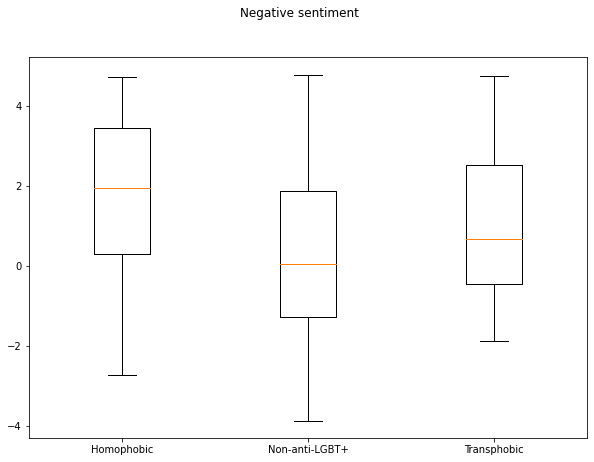

In [6]:
import matplotlib.pyplot as plt

homo = newpd[newpd[0]==0][2]
non = newpd[newpd[0]==1][2]
trans = newpd[newpd[0]==2][2] 

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
plt.boxplot([homo,non,trans])
fig.suptitle('Negative sentiment')
ax.set_xticklabels(['Homophobic', 'Non-anti-LGBT+', 'Transphobic'])
fig.savefig('negative-sentiment-tam-eng.jpg')

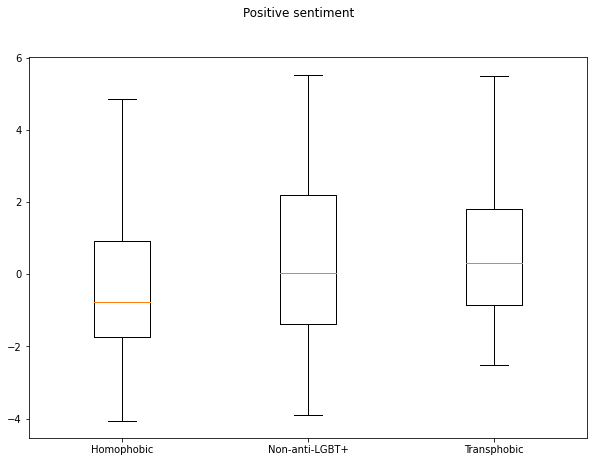

In [7]:
homo = newpd[newpd[0]==0][3]
non = newpd[newpd[0]==1][3]
trans = newpd[newpd[0]==2][3] 

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
plt.boxplot([homo,non,trans])
fig.suptitle('Positive sentiment')
ax.set_xticklabels(['Homophobic', 'Non-anti-LGBT+', 'Transphobic'])
fig.savefig('positive-sentiment-tam-eng.jpg')

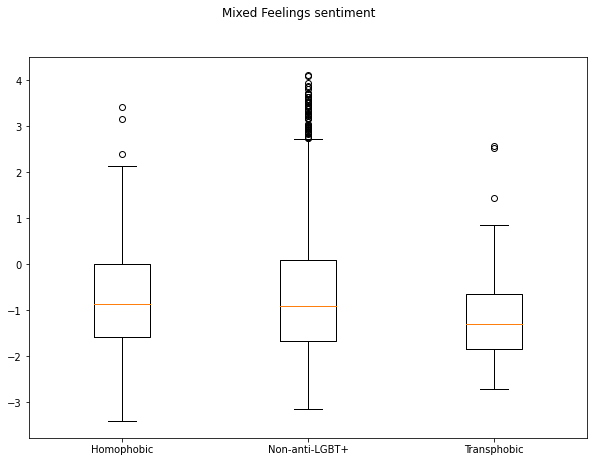

In [8]:
homo = newpd[newpd[0]==0][1]
non = newpd[newpd[0]==1][1]
trans = newpd[newpd[0]==2][1] 

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
plt.boxplot([homo,non,trans])
fig.suptitle('Mixed Feelings sentiment')
ax.set_xticklabels(['Homophobic', 'Non-anti-LGBT+', 'Transphobic'])
fig.savefig('mixed_feelings-sentiment-tam-eng.jpg')